In [23]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
import torchbnn as bnn

In [42]:
# Load Data
colectomy_cci_var = pd.read_csv('./colectomy_cci_var.csv', dtype = 'str')

# Select Relevant Features
features = ['year', 'ptsex', 'race', 'age', 'adtype', 'adsource', 'admdx']

num_secondary_admissions = 10

for i in range(1, num_secondary_admissions + 1):
    sdx = f'sdx{i}'
    features.append(sdx)
    colectomy_cci_var[sdx] = colectomy_cci_var[sdx].fillna("unknown")

#colectomy_cci_var['sdx1'] = colectomy_cci_var['sdx1'].fillna("unknown")
#colectomy_cci_var['sdx2'] = colectomy_cci_var['sdx2'].fillna("unknown")

#colectomy_cci_var['ptsex'] = colectomy_cci_var['ptsex'].replace({'F': 'female', 'M': 'male'})
colectomy_cci_var['adtype'] = colectomy_cci_var['adtype'].replace({'1': 'emergency', '2': 'urgent', '3': 'elective'})
colectomy_cci_var['adsource'] = colectomy_cci_var['adsource'].replace({'1': 'non_healthcare_facility', '2': 'clinical_referral', '4': 'hospital_transfer', '5': 'snf_icf_transfer', '6': 'healthcare_facility_tranfer', '7': 'emergency_room', '8': 'court_law_enforcement', 'D': 'hospital_unit_transfer', 'E': 'ambulatory_surgery_center'})

# Drop observations
colectomy_cci_var = colectomy_cci_var[colectomy_cci_var['adsource'] != '9']

#for feature in features:
#    print(colectomy_cci_var[feature].value_counts())


In [ ]:
colectomy_cci_var_X = colectomy_cci_var[features]
colectomy_cci_var_y = colectomy_cci_var['pdx']

#colectomy_cci_var_X_encoded = pd.get_dummies(colectomy_cci_var_X, columns = ['ptsex', 'race', 'adtype', 'adsource', 'admdx', 'sdx1', 'sdx2'])
colectomy_cci_var_X_encoded = 
# Split Data
train_X, test_X, train_y, test_y = train_test_split(colectomy_cci_var_X_encoded, colectomy_cci_var_y, test_size = 0.2, random_state = 0)

# Normalize Data
train_X

,year,age,ptsex_F,ptsex_M,race_A,race_B,race_I,race_M,race_N,race_P,...,sdx2_V8539,sdx2_V854,sdx2_V8541,sdx2_V8542,sdx2_V8543,sdx2_V8544,sdx2_V8545,sdx2_V8741,sdx2_V8801,sdx2_unknown
2642,2011,79,False,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
22463,2012,82,False,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
23632,2012,61,True,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
12287,2014,53,False,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
15510,2011,68,True,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20758,2011,62,True,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
32106,2012,50,True,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
30405,2013,74,True,False,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
21244,2013,53,True,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True


(array([5511., 8221., 3722., 1864., 1678., 1728., 1516.,  975.,  827.,
         782.,  562.,  671.,  437.,  862.,  344.,  679.,  720.,  449.,
         226.,  342.,  230.,  172.,  224.,  358.,  418.,  228.,  200.,
         279.,  229.,  121.,  141.,  205.,  179.,  193.,   99.,   75.,
         187.,  136.,   83.,  114.,  144.,   80.,  127.,   82.,   94.,
          71.,   52.,   64.,   65.,   47.,   54.,   60.,   66.,   57.,
          66.,   52.,   62.,   61.,   68.,   43.,   56.,   62.,   47.,
          42.,   60.,   39.,   33.,   34.,   35.,   36.,   41.,   30.,
          35.,   27.,   35.,   27.,   30.,   33.,   32.,   34.,   37.,
          26.,   28.,   30.,   28.,   23.,   22.,   22.,   25.,   23.,
          20.,   19.,   24.,   20.,   19.,   23.,   18.,   22.,   18.,
          18.]),
 array([   0.  ,   17.68,   35.36,   53.04,   70.72,   88.4 ,  106.08,
         123.76,  141.44,  159.12,  176.8 ,  194.48,  212.16,  229.84,
         247.52,  265.2 ,  282.88,  300.56,  318.24,  335.92

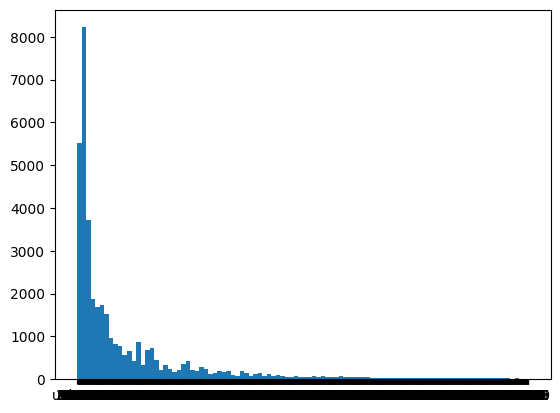

In [21]:
plt.hist(colectomy_cci_var['sdx2'], bins=100)


In [15]:
k = 20
print(len(colectomy_cci_var))
colectomy_cci_var_filtered_1 = colectomy_cci_var.groupby('admdx').filter(lambda x: len(x) >= k)
print(len(colectomy_cci_var_filtered_1))
colectomy_cci_var_filtered_2 = colectomy_cci_var_filtered_1.groupby('sdx1').filter(lambda x: len(x) >= k)
print(len(colectomy_cci_var_filtered_2))
colectomy_cci_var_filtered_3 = colectomy_cci_var_filtered_2.groupby('sdx2').filter(lambda x: len(x) >= k)
print(len(colectomy_cci_var_filtered_3))

38635
36240
31889
27115


In [ ]:
# Model Architecture
class BayesianNeuralNetwork(nn.Module):
    def __init__(self, feature_size, num_classes):
        super().__init__()

        layer_1_size = 100
        layer_2_size = 50

        # Layers
        self.bayes_linear_1 = bnn.BayesLinear(prior_mu = 0, prior_sigma = 1, in_features = feature_size, out_features = layer_1_size)
        self.bayes_linear_2 = bnn.BayesLinear(prior_mu = 0, prior_sigma = 1, in_features = layer_1_size, out_features = layer_2_size)
        self.output_layer = nn.Linear(in_features = layer_2_size, out_features = num_classes)
    
    def forward(self, x):
        x = torch.relu(self.bayes_linear_1(x))
        x = torch.relu(self.bayes_linear_2(x))
        return self.output_layer(x)

In [ ]:
# Loss Function
def elbo_loss(output, target, model):
    standard_loss = nn.CrossEntropyLoss(output, target)
    kl_loss = bnn.BKLLoss(reduction = 'mean', last_layer_only = False)

    return standard_loss + kl_loss(model)